In [73]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.impute import KNNImputer
from geopy.distance import geodesic
import seaborn as sns
import matplotlib.pyplot as plt
import joblib as jb
from sklearn.pipeline import make_pipeline

# Classificadores:
from sklearn.neighbors import NearestNeighbors
# Regressor:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Metricas:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

## 1) Loading Data

In [4]:
def dataset_recomendacao():
    df_municipios_sertao = pd.read_csv(r"..\Dados\Views\municipios_sertao.csv", index_col=0)
    df_meteorologia = pd.read_csv("..\Dados\Views\dados_meteorologicos.csv", index_col=0)
    df_solo = pd.read_csv(r"..\Dados\Views\solos_municipios.csv", index_col=0)
    df_recursos_hidricos = pd.read_csv(r"..\Dados\Views\recursos_hidricos.csv", index_col=0)
    df_classificador = df_municipios_sertao[["IBGE7", "NOME"]].copy()
    
    # Merges com o dataframe do classificador:
    df_classificador = df_classificador.merge(df_meteorologia, on="IBGE7", how="left")
    df_classificador = df_classificador.merge(df_recursos_hidricos[["IBGE7", "AREA_IRRIGADA_TOT"]], on="IBGE7", how="left")

    # Obtendo solo de maior área dentro do município
    df_solo_esparsa = df_solo.pivot_table(index="IBGE7", columns="SOLO", values="AREA_TOTAL").fillna(value=0).reset_index()
    df_classificador = df_classificador.merge(df_solo_esparsa, how="inner", on="IBGE7")
    return df_classificador
    
    
def recomendacao_preprocessamento(dataset):
    X = dataset.drop(columns=["IBGE7", "NOME"])
    cat_columns = [i for i in X.columns if i in X.iloc[:, 6:].columns]
    #colunas_num = [i for i in X.columns if i not in cat_columns]
    colunas_log = [i for i in X.columns if (i not in cat_columns)&(i not in ["LATITUDE", "LONGITUDE"])]
    
    # Aplicando log transformation para conter a variabilidade dos dados:
    log_transformation = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)
    X[colunas_log] = log_transformation.transform(X[colunas_log])

    # Aplicando MinMax scaler para conter o range dos dados:
    min_max = MinMaxScaler()
    colunas_totais = X.columns
    X[colunas_totais] = min_max.fit_transform(X[colunas_totais])

    # Aplicando imputação dos dados:
    imputer = KNNImputer(n_neighbors=5)
    X_imputado = pd.DataFrame(imputer.fit_transform(X))
    X_imputado.columns = X.columns
    return X_imputado


def recomendacao_logica(nome_municipio="ITAPICURU", k_neighburs=5):
    model_knn = jb.load(r"..\Dashboards\models\knn.pkl", mmap_mode="r")
    dataset = dataset_recomendacao()
    dados_preprocessado = recomendacao_preprocessamento(dataset)
    index_municipio = dataset[dataset["NOME"] == nome_municipio].index[0]
    input_recomendacao = dados_preprocessado.iloc[[index_municipio]]
    distance, neighbours_indices = model_knn.kneighbors(input_recomendacao, n_neighbors=k_neighburs+1)
    neighbours_indices_corrigidos = neighbours_indices[0][1:]
    vizinhos = dataset.iloc[neighbours_indices_corrigidos]
    recomendacao = filtro_recomendacao(vizinhos, nome_potencial_mun=nome_municipio)
    return vizinhos, recomendacao




def recomendacao_fisica(nome_potencial_mun="ITAPICURU", raio=50):
    df_municipios_sertao = pd.read_csv(r"..\Dados\Views\municipios_sertao.csv", index_col=0)
    codigo_mun_potencial = df_municipios_sertao[df_municipios_sertao["NOME"] == nome_potencial_mun]["IBGE7"].values[0]
    municipios_vizinhos = distancia_circular(df_municipios_sertao, threhold=raio, municipio_start=nome_potencial_mun)
    recomendacao = filtro_recomendacao(municipios_vizinhos, nome_potencial_mun)
    return recomendacao



def filtro_recomendacao(vizinhos, nome_potencial_mun):
    df_produto_agricola = pd.read_csv(r"..\Dados\Tabela_final\dados_producao_agricola.csv", index_col=0)
    
    # Calculo do Valor da Produção por área plantada para avaliar se há subexploração:
    df_produto_agricola["VALOR_POR_AREA_PLANTADA"] = df_produto_agricola["VALOR_PROD"] / df_produto_agricola["AREA_PLANTADA"]

    # Produtos produzidos:
    df_cidade_escolhida = df_produto_agricola[df_produto_agricola["NOME"] == nome_potencial_mun].sort_values("VALOR_PROD", ascending=False)
    
    # Rendimento por área dos vizinhos lógicos de ITAPICURU:
    df_agrupado = df_produto_agricola[df_produto_agricola["NOME"].isin(vizinhos["NOME"].values)]

    # Média do Valor produzido dos produtos cultivados pelos vizinhos:
    df_agrupado = df_agrupado.groupby("PRODUTO").agg({"VALOR_PROD":"mean",
                                                  "AREA_PLANTADA":"mean",
                                                   "VALOR_POR_AREA_PLANTADA":"mean"}).sort_values("VALOR_PROD", ascending=False)
    

    df_agrupado.rename(columns={"VALOR_PROD": "VALOR_PROD_MEDIA_VIZ",
                                "AREA_PLANTADA":"AREA_PLANTADA_MED_VIZ", 
                                "VALOR_POR_AREA_PLANTADA":"VALOR_POR_AREA_PLANTADA_MEDIA_VIZ"},inplace=True)
    
    df_agrupado = df_agrupado.reset_index()

    # Seleção dos produtos mais interessantes:
    df_comparativo = df_agrupado.merge(df_cidade_escolhida[["PRODUTO","VALOR_PROD", 
                                                                    "VALOR_POR_AREA_PLANTADA"]], on="PRODUTO", how="left")
    df_comparativo.rename(columns={"VALOR_PROD":f"VALOR_PROD_{nome_potencial_mun}", 
                                "VALOR_POR_AREA_PLANTADA":f"VALOR_POR_AREA_PLANT_{nome_potencial_mun}"}, inplace=True)

    df_comparativo = df_comparativo.fillna(0)
    nome_coluna_selecao1 = f"VALOR_PROD_{nome_potencial_mun}"
    nome_coluna_selecao2 = f"VALOR_POR_AREA_PLANT_{nome_potencial_mun}"
    condicao_selecao1 = (df_comparativo[nome_coluna_selecao1] < df_comparativo["VALOR_PROD_MEDIA_VIZ"])
    condicao_selecao2 = (df_comparativo[nome_coluna_selecao2] < df_comparativo["VALOR_POR_AREA_PLANTADA_MEDIA_VIZ"])    
    return df_comparativo[condicao_selecao1&condicao_selecao2]


# Função para calcular a distância em KM, entre duas coordenadas geográficas:
def distancia_circular(df_municipios_sertao, threhold, municipio_start):
    dicionario_distancias = {}
    lista_distancias = []
    municipio_escolhido = df_municipios_sertao[df_municipios_sertao["NOME"] == municipio_start][["LATITUDE", "LONGITUDE"]]
    for municipio_qualquer, row2 in df_municipios_sertao[["LATITUDE", "LONGITUDE"]].iterrows():
        nome = df_municipios_sertao.loc[municipio_qualquer, "NOME"]
        uf = df_municipios_sertao.loc[municipio_qualquer, "UF"]
        ibge = df_municipios_sertao.loc[municipio_qualquer, "IBGE7"]
        if municipio_start != nome:
            distancia = geodesic(municipio_escolhido.values, row2.values).kilometers
            if distancia <= threhold:
                lista_distancias.append((ibge, nome, uf,distancia))
    
        #dicionario_distancias[df_municipios_sertao.loc[municipio_qualquer, "NOME"]] = lista_distancias
    return pd.DataFrame(lista_distancias, columns=["IBGE7", "NOME", "UF", "DISTANCIAS"])
    

In [5]:
df_meteorologia = pd.read_csv("..\Dados\Views\dados_meteorologicos.csv", index_col=0)
df_produto_agricola = pd.read_csv(R"..\Dados\Tabela_final\dados_producao_agricola.csv", index_col=0)
df_municipios_sertao = pd.read_csv(r"..\Dados\Views\municipios_sertao.csv", index_col=0)
df_recursos_hidricos = pd.read_csv(r"..\Dados\Views\recursos_hidricos.csv", index_col=0)
df_solo = pd.read_csv(r"..\Dados\Views\solos_municipios.csv", index_col=0)

In [ ]:
df_classificador = dataset_recomendacao()

## 2) Identificar vizinhos Lógicos utilizando Nearest Neighbours

### 2.1) Pré-processamento

In [46]:
X = df_classificador.drop(columns=["IBGE7", "NOME"])

In [47]:
cat_columns = [i for i in X.columns if i in X.iloc[:, 6:].columns]
colunas_num = [i for i in X.columns if i not in cat_columns]
colunas_log = [i for i in X.columns if (i not in cat_columns)&(i not in ["LATITUDE", "LONGITUDE"])]

In [48]:
# Aplicando log transformation para conter a variabilidade dos dados:
log_transformation = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)
X[colunas_log] = log_transformation.transform(X[colunas_log])

In [49]:
# Aplicando MinMax scaler para conter o range dos dados:
min_max = MinMaxScaler()
colunas_totais = X.columns
X[colunas_totais] = min_max.fit_transform(X[colunas_totais])

In [50]:
imputer = KNNImputer(n_neighbors=5)
X_imputado = pd.DataFrame(imputer.fit_transform(X))
X_imputado.columns = X.columns

In [51]:
X_imputado

,PREC_MED,RED_MED,TEMP_MED,VEL_MED,ALTITUDE,AREA_IRRIGADA_TOT,AGUA,CXbd - Cambissolos Haplicos Tb Distroficos,CXbe - Cambissolos Haplicos Tb Eutroficos,CXve - Cambissolos Haplicos Ta Eutroficos,...,RLe - Neossolos Litolicos Eutroficos,RQo - Neossolos Quartzarenicos Orticos,RRe - Neossolos Regoliticos Eutroficos,RYve - Neossolos Fluvicos Ta Eutroficos,SNo - Planossolos Natricos Orticos,SXe - Planossolos Haplicos Eutroficos,TCo - Luvissolos Cromicos Orticos,TCp - Luvissolos Cromicos Palicos,VEo - Vertissolos Ebanicos Orticos,VXo - Vertissolos Haplicos Orticos
0,0.819860,0.661136,0.647071,0.410457,0.675412,0.538109,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.00000,0.000006,0.0,0.0,0.0,0.0
1,0.724461,0.770893,0.770942,0.382409,0.215853,0.000000,0.000000,0.0,0.0,0.000000,...,0.052826,0.000000,0.000000,0.0,0.00000,0.017522,0.0,0.0,0.0,0.0
2,0.724461,0.770893,0.770942,0.382409,0.215853,0.000000,0.009459,0.0,0.0,0.000000,...,0.064447,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
3,0.367246,0.859949,0.672902,0.292261,0.706131,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.015099,0.0,0.00000,0.078041,0.0,0.0,0.0,0.0
4,0.649550,0.812645,0.716960,0.587898,0.630163,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.307012,0.0,0.00000,0.093297,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,0.527338,0.703019,0.713979,0.660902,0.655088,0.000000,0.000000,0.0,0.0,0.000000,...,0.035625,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
1254,0.547235,0.904856,0.744446,0.621853,0.701235,0.000000,0.000000,0.0,0.0,0.000000,...,0.022745,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
1255,0.293501,0.789307,0.637230,0.188926,0.759405,0.330814,0.000000,0.0,0.0,0.042548,...,0.085501,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
1256,0.944977,0.870876,0.703595,0.320304,0.000000,0.545207,0.006516,0.0,0.0,0.000000,...,0.004954,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0


### 2.2) Aplicando Nearest Neighbours

In [11]:
X_imputado = pd.read_csv(r"..\Dados\Views\dataset_knn_processado.csv", index_col=["IBGE7", "NOME"])
X_imputado

,,PREC_MED,RED_MED,TEMP_MED,AREA_IRRIGADA_TOT_POT_E,AGUA_SOLO,QUAL_MED_AGUA,AGUA,CXbd - Cambissolos Haplicos Tb Distroficos,CXbe - Cambissolos Haplicos Tb Eutroficos,CXve - Cambissolos Haplicos Ta Eutroficos,...,RLe - Neossolos Litolicos Eutroficos,RQo - Neossolos Quartzarenicos Orticos,RRe - Neossolos Regoliticos Eutroficos,RYve - Neossolos Fluvicos Ta Eutroficos,SNo - Planossolos Natricos Orticos,SXe - Planossolos Haplicos Eutroficos,TCo - Luvissolos Cromicos Orticos,TCp - Luvissolos Cromicos Palicos,VEo - Vertissolos Ebanicos Orticos,VXo - Vertissolos Haplicos Orticos
IBGE7,NOME,,,,,,,,,,,,,,,,,,,,,
2700300,ARAPIRACA,0.739495,0.629208,0.629657,0.530426,0.228028,0.738419,0.000000,0.0,0.0,0.00000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000006,0.0,0.0,0.0,0.0
2700706,BATALHA,0.644782,0.788270,0.770947,0.000000,0.275544,0.786691,0.000000,0.0,0.0,0.00000,...,0.052903,0.000000,0.000000,0.0,0.000000,0.017517,0.0,0.0,0.0,0.0
2700904,BELO MONTE,0.644782,0.788270,0.770947,0.000000,0.177402,0.786691,0.009448,0.0,0.0,0.00000,...,0.064522,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
2701209,CACIMBINHAS,0.466144,0.866118,0.672910,0.000000,0.286171,0.786691,0.000000,0.0,0.0,0.00000,...,0.000000,0.000000,0.015148,0.0,0.000000,0.078062,0.0,0.0,0.0,0.0
2701605,CANAPI,0.568439,0.809665,0.716966,0.000000,0.268358,0.832744,0.000000,0.0,0.0,0.00000,...,0.000000,0.000000,0.308296,0.0,0.000000,0.093393,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2806008,RIBEIROPOLIS,0.448118,0.697965,0.713985,0.000000,0.662436,0.756165,0.000000,0.0,0.0,0.00000,...,0.035588,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
2807006,SAO MIGUEL DO ALEIXO,0.603391,0.788697,0.605880,0.000000,0.710388,0.756165,0.000000,0.0,0.0,0.00000,...,0.022730,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
2807105,SIMAO DIAS,0.486414,0.773543,0.609846,0.326090,0.506376,0.756165,0.000000,0.0,0.0,0.04248,...,0.085340,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


In [12]:
k_neighburs = 5 
knn = NearestNeighbors(n_neighbors=k_neighburs, n_jobs=-1, metric="cosine")
knn.fit(X_imputado)

NearestNeighbors(metric='cosine', n_jobs=-1)

In [13]:
jb.dump(knn, r"..\Dashboards\models\knn.pkl")

['..\\Dashboards\\models\\knn.pkl']

In [54]:
model_knn = jb.load("../Dashboards/models/knn.pkl", mmap_mode="r")

In [57]:
distance, neighbours_indices = knn.kneighbors(X_imputado, n_neighbors=k_neighburs+1)

#### 2.2.1) ITAPICURU

In [58]:
# Escolha do município a ser avaliado
nome_potencial_mun = "ITAPICURU"
codigo_mun_potencial = df_municipios_sertao[df_municipios_sertao["NOME"] == nome_potencial_mun]["IBGE7"].values[0]

In [59]:
# Selecionandos vizinhos de ITAPICURU:
index_nn = df_classificador[df_classificador["NOME"] == nome_potencial_mun].index[0]
distancias_corrigidas = distance[index_nn][1:]
neighbours_indices_corrigidos = neighbours_indices[index_nn][1:]

In [61]:
# Vizinhos lógicos de ITAPICURU:
colunas_avaliadoras = ["IBGE7","NOME"] + colunas_num
vizinhos = df_classificador.iloc[neighbours_indices_corrigidos][colunas_avaliadoras]
vizinhos

,IBGE7,NOME,PREC_MED,RED_MED,TEMP_MED,VEL_MED,ALTITUDE,AREA_IRRIGADA_TOT
522,3133303,ITAOBIM,909.968978,1166.031941,25.293975,1.879541,271.63,395.00000
146,2913705,INHAMBUPE,729.771173,1066.567575,25.173941,2.634640,337.79,1770.04332
257,2926608,RIBEIRA DO POMBAL,778.182862,1034.162314,25.419589,2.172381,182.00,509.00000
256,2926509,RIBEIRA DO AMPARO,778.182862,1034.162314,25.419589,2.172381,182.00,1545.74325
523,3134004,ITINGA,909.968978,1166.031941,25.293975,1.879541,271.63,668.00000


In [62]:
# Calculo do Valor da Produção por área plantada para avaliar se há subexploração:
df_produto_agricola["VALOR_POR_AREA_PLANTADA"] = df_produto_agricola["VALOR_PROD"] / df_produto_agricola["AREA_PLANTADA"]

In [63]:
# Produtos produzidos em ITAPICURO:
df_cidade_escolhida = df_produto_agricola[df_produto_agricola["NOME"] == nome_potencial_mun].sort_values("VALOR_PROD", ascending=False)
df_cidade_escolhida

,NOME,PRODUTO,AREA_PLANTADA,AREA_COLHIDA,REND_MEDIO,VALOR_PROD,VALOR_POR_AREA_PLANTADA
21805,ITAPICURU,MILHO (EM GRAO),19333.333333,19333.333333,3689.000000,70163.666667,3.629155
21801,ITAPICURU,MANDIOCA,6266.666667,4133.333333,9092.666667,28589.000000,4.562074
21804,ITAPICURU,MELAO,223.666667,223.666667,21234.666667,4674.666667,20.900149
21792,ITAPICURU,CASTANHA DE CAJU,1295.666667,1295.666667,310.000000,1535.000000,1.184718
21795,ITAPICURU,FEIJAO (EM GRAO),1006.666667,1006.666667,270.666667,1241.333333,1.233113
21803,ITAPICURU,MELANCIA,133.666667,133.666667,8848.333333,880.333333,6.586035
21784,ITAPICURU,BANANA,20.000000,20.000000,13433.333333,569.666667,28.483333
21808,ITAPICURU,SOJA (EM GRAO),51.666667,51.666667,2995.000000,309.000000,5.980645


In [65]:
# Produtos produzidos nos vizinhos:
df_recomendados = df_produto_agricola[df_produto_agricola["NOME"].isin(vizinhos["NOME"].values)].sort_values("NOME", ascending=False)
df_recomendados.merge(df_municipios_sertao[["UF", "NOME"]], on="NOME", how="inner")

,NOME,PRODUTO,AREA_PLANTADA,AREA_COLHIDA,REND_MEDIO,VALOR_PROD,VALOR_POR_AREA_PLANTADA,UF
0,RIBEIRA DO POMBAL,MILHO (EM GRAO),3166.666667,3166.666667,1593.333333,6143.666667,1.940105,BA
1,RIBEIRA DO POMBAL,MELANCIA,120.000000,111.666667,50000.000000,2558.333333,21.319444,BA
2,RIBEIRA DO POMBAL,MANGA,7.000000,7.000000,4761.666667,37.666667,5.380952,BA
3,RIBEIRA DO POMBAL,MANDIOCA,300.000000,280.000000,12133.333333,1288.333333,4.294444,BA
4,RIBEIRA DO POMBAL,FEIJAO (EM GRAO),866.666667,866.666667,231.666667,1019.000000,1.175769,BA
5,RIBEIRA DO POMBAL,CASTANHA DE CAJU,2300.000000,2300.000000,220.000000,2123.666667,0.923333,BA
6,RIBEIRA DO POMBAL,BANANA,8.000000,8.000000,9208.333333,162.333333,20.291667,BA
7,RIBEIRA DO AMPARO,MANDIOCA,70.000000,70.000000,1904.666667,126.000000,1.800000,BA
8,RIBEIRA DO AMPARO,AMENDOIM (EM CASCA),50.000000,50.000000,720.000000,113.000000,2.260000,BA
9,RIBEIRA DO AMPARO,BANANA,45.000000,45.000000,12614.666667,1176.000000,26.133333,BA


In [67]:
# Rendimento por área dos vizinhos lógicos de ITAPICURU:
df_agrupado = df_produto_agricola[df_produto_agricola["NOME"].isin(vizinhos["NOME"].values)]

# Média do Valor produzido dos produtos cultivados pelos vizinhos:
df_agrupado = df_agrupado.groupby("PRODUTO").agg({"VALOR_PROD":"mean",
                                                  "AREA_PLANTADA":"mean",
                                                   "VALOR_POR_AREA_PLANTADA":"mean"}).sort_values("VALOR_PROD", ascending=False)

df_agrupado.rename(columns={"VALOR_PROD": "VALOR_PROD_MEDIA_SEMELHANTES",
                            "AREA_PLANTADA":"AREA_PLANTADA_MED_SEMELHANTE", 
                            "VALOR_POR_AREA_PLANTADA":"VALOR_POR_AREA_PLANTADA_MEDIA_SEMELHANTES"},inplace=True)
df_agrupado = df_agrupado.reset_index()
df_agrupado

,PRODUTO,VALOR_PROD_MEDIA_SEMELHANTES,AREA_PLANTADA_MED_SEMELHANTE,VALOR_POR_AREA_PLANTADA_MEDIA_SEMELHANTES
0,MELAO,40735.666667,1287.000000,31.651645
1,MILHO (EM GRAO),10047.266667,3174.666667,2.020938
2,MANDIOCA,2263.933333,373.666667,4.792546
3,MELANCIA,1584.800000,75.533333,15.779069
4,FEIJAO (EM GRAO),1533.066667,828.533333,1.996406
5,BANANA,1515.266667,60.733333,24.240776
6,CASTANHA DE CAJU,1260.500000,1288.666667,1.178013
7,MANGA,261.333333,15.500000,11.393006
8,AMENDOIM (EM CASCA),192.666667,52.500000,3.605758
9,PIMENTA-DO-REINO,44.333333,2.000000,22.166667


In [68]:
# Seleção dos produtos mais interessantes:
df_comparativo = df_agrupado.merge(df_cidade_escolhida[["PRODUTO","VALOR_PROD", 
                                                                   "VALOR_POR_AREA_PLANTADA"]], on="PRODUTO", how="left")
df_comparativo.rename(columns={"VALOR_PROD":f"VALOR_PROD_{nome_potencial_mun}", 
                               "VALOR_POR_AREA_PLANTADA":f"VALOR_POR_AREA_PLANT_{nome_potencial_mun}"}, inplace=True)

df_comparativo = df_comparativo.fillna(0)

nome_coluna_selecao1 = f"VALOR_PROD_{nome_potencial_mun}"
nome_coluna_selecao2 = f"VALOR_POR_AREA_PLANT_{nome_potencial_mun}"
condicao_selecao1 = (df_comparativo[nome_coluna_selecao1] < df_comparativo["VALOR_PROD_MEDIA_SEMELHANTES"])
condicao_selecao2 = (df_comparativo[nome_coluna_selecao2] < df_comparativo["VALOR_POR_AREA_PLANTADA_MEDIA_SEMELHANTES"])
df_comparativo[condicao_selecao1&condicao_selecao2]

,PRODUTO,VALOR_PROD_MEDIA_SEMELHANTES,AREA_PLANTADA_MED_SEMELHANTE,VALOR_POR_AREA_PLANTADA_MEDIA_SEMELHANTES,VALOR_PROD_ITAPICURU,VALOR_POR_AREA_PLANT_ITAPICURU
0,MELAO,40735.666667,1287.000000,31.651645,4674.666667,20.900149
3,MELANCIA,1584.800000,75.533333,15.779069,880.333333,6.586035
4,FEIJAO (EM GRAO),1533.066667,828.533333,1.996406,1241.333333,1.233113
7,MANGA,261.333333,15.500000,11.393006,0.000000,0.000000
8,AMENDOIM (EM CASCA),192.666667,52.500000,3.605758,0.000000,0.000000
9,PIMENTA-DO-REINO,44.333333,2.000000,22.166667,0.000000,0.000000
10,CAFE (EM GRAO) CANEPHORA,4.333333,0.666667,6.500000,0.000000,0.000000
11,CAFE (EM GRAO) TOTAL,4.333333,0.666667,6.500000,0.000000,0.000000


Conclusões:
- ITAPICURU está abaixo da média comparada com seus semelhantes em questão de Valor de Produção: 
     1. Melão - 4674.666667
     2. Feijão (Em grão) - 1241.333333
     3. Melancia - 880.333333
     4. Banana - 569.666667
     

- Dado os produtos em que ITAPICURU produz abaixo da média de seus semelhantes, percebemos que o Melão, Melancia e Feijão têm um valor por área médio de seus semelhantes bem superior ao de ITAPICURU (Melão=20.900149, Melancia=6.586035, Feijão=1.233113).

- Foi indicado pelo algoritmo, e que não é produzido em ITAPICURU, a produção de MANGA, AMENDOIM (EM CASCA), PIMENTA-DO-REINO, CAFE (EM GRAO) CANEPHORA e CAFE (EM GRAO) TOTAL.

#### 2.2.2) ITAPICURU análise de solos

In [70]:
# Solos que podemos encontrar em ITAPICURU:
df_solo[df_solo["IBGE7"].isin([2916500])].merge(df_municipios_sertao[["NOME", "UF", "IBGE7"]], on="IBGE7", how="inner")

,IBGE7,SOLO,AREA_TOTAL,NOME,UF
0,2916500,LAd - Latossolos Amarelos Distroficos,18032.365183,ITAPICURU,BA
1,2916500,PVAd - Argissolos Vermelho-Amarelos Distroficos,46579.916148,ITAPICURU,BA
2,2916500,RQo - Neossolos Quartzarenicos Orticos,86920.869936,ITAPICURU,BA
3,2916500,SNo - Planossolos Natricos Orticos,15514.030117,ITAPICURU,BA


In [71]:
# Solos dos vizinhos lógicos identificados:
df_municipios_sertao[["NOME", "UF", "IBGE7"]].merge(df_solo[df_solo["IBGE7"].isin(vizinhos["IBGE7"].values)], on="IBGE7", how="inner")

,NOME,UF,IBGE7,SOLO,AREA_TOTAL
0,INHAMBUPE,BA,2913705,LAd - Latossolos Amarelos Distroficos,63582.129104
1,INHAMBUPE,BA,2913705,PVAd - Argissolos Vermelho-Amarelos Distroficos,26682.523981
2,INHAMBUPE,BA,2913705,PVAe - Argissolos Vermelho-Amarelos Eutroficos,39266.429269
3,RIBEIRA DO AMPARO,BA,2926509,LAd - Latossolos Amarelos Distroficos,3967.166293
4,RIBEIRA DO AMPARO,BA,2926509,RQo - Neossolos Quartzarenicos Orticos,61605.365659
5,RIBEIRA DO AMPARO,BA,2926509,SNo - Planossolos Natricos Orticos,1333.137921
6,RIBEIRA DO POMBAL,BA,2926608,LAd - Latossolos Amarelos Distroficos,4236.562031
7,RIBEIRA DO POMBAL,BA,2926608,PVAd - Argissolos Vermelho-Amarelos Distroficos,1455.611775
8,RIBEIRA DO POMBAL,BA,2926608,RQo - Neossolos Quartzarenicos Orticos,75067.891352
9,ITAOBIM,MG,3133303,LVAd - Latossolos Vermelho-Amarelos Distroficos,14457.136400


## 3) Similaridade Geográfica a partir da distância

In [72]:
# Função para calcular a distância em KM, entre duas coordenadas geográficas:
def distancia_circular(df_municipios_sertao, threhold, municipio_start):
    dicionario_distancias = {}
    lista_distancias = []
    municipio_escolhido = df_municipios_sertao[df_municipios_sertao["NOME"] == municipio_start][["LATITUDE", "LONGITUDE"]]
    for municipio_qualquer, row2 in df_municipios_sertao[["LATITUDE", "LONGITUDE"]].iterrows():
        nome = df_municipios_sertao.loc[municipio_qualquer, "NOME"]
        uf = df_municipios_sertao.loc[municipio_qualquer, "UF"]
        ibge = df_municipios_sertao.loc[municipio_qualquer, "IBGE7"]
        if municipio_start != nome:
            distancia = geodesic(municipio_escolhido.values, row2.values).kilometers
            if distancia <= threhold:
                lista_distancias.append((ibge, nome, uf,distancia))
    
        #dicionario_distancias[df_municipios_sertao.loc[municipio_qualquer, "NOME"]] = lista_distancias
    return pd.DataFrame(lista_distancias, columns=["IBGE7", "MUNICIPIOS", "UF", "DISTANCIAS"])

### 3.1) ITAPICURU vizinhos físicos

In [73]:
# Escolha do município a ser avaliado
nome_potencial_mun = "ITAPICURU"
codigo_mun_potencial = df_municipios_sertao[df_municipios_sertao["NOME"] == nome_potencial_mun]["IBGE7"].values[0]
criterio_distancia = 50

In [74]:
# Calculo das distâncias deste município até otros:
municipios_vizinhos = distancia_circular(df_municipios_sertao, threhold=criterio_distancia, municipio_start=nome_potencial_mun)
municipios_vizinhos

,IBGE7,MUNICIPIOS,UF,DISTANCIAS
0,2907905,CIPO,BA,39.141885
1,2909604,CRISOPOLIS,BA,23.277050
2,2922904,NOVA SOURE,BA,29.698246
3,2923100,OLINDINA,BA,13.005937
4,2926509,RIBEIRA DO AMPARO,BA,36.578826
5,2807402,TOBIAS BARRETO,SE,28.573107


In [79]:
# Produtos plantados pelos vizinhos de ITAPECURU:
ibge_codigos = municipios_vizinhos["MUNICIPIOS"].values
df_vizinhos_fisicos_prod = df_produto_agricola[df_produto_agricola["NOME"].isin(ibge_codigos)]
df_vizinhos_fisicos_prod

,NOME,PRODUTO,AREA_PLANTADA,AREA_COLHIDA,REND_MEDIO,VALOR_PROD,VALOR_POR_AREA_PLANTADA
11955,CIPO,AMENDOIM (EM CASCA),60.000000,60.000000,539.000000,101.000000,1.683333
11956,CIPO,BANANA,15.333333,15.333333,8455.666667,213.333333,13.913043
11964,CIPO,CASTANHA DE CAJU,72.000000,72.000000,500.000000,136.000000,1.888889
11967,CIPO,FEIJAO (EM GRAO),131.333333,131.333333,99.000000,52.000000,0.395939
11973,CIPO,MANDIOCA,17.000000,17.000000,2941.333333,36.666667,2.156863
11974,CIPO,MANGA,4.000000,4.000000,2000.000000,9.333333,2.333333
11975,CIPO,MELANCIA,15.333333,15.333333,13933.333333,154.333333,10.065217
11977,CIPO,MILHO (EM GRAO),135.000000,135.000000,249.000000,34.666667,0.256790
11982,CIPO,TOMATE,3.666667,3.666667,39361.000000,371.333333,101.272727
13431,CRISOPOLIS,AMENDOIM (EM CASCA),35.000000,35.000000,1219.000000,166.333333,4.752381


In [80]:
# Métricas descritivas dos VALOR DE PRODUÇÃO e do VALOR POR ÁREA PLANTADA ao redor de ITAPICURU:
df_agrupado_viz_fisico = df_vizinhos_fisicos_prod.groupby("PRODUTO").agg({"VALOR_PROD":"mean",
                                                                          "AREA_PLANTADA":"mean",
                                                                          "VALOR_POR_AREA_PLANTADA":"mean"}).sort_values("VALOR_PROD", ascending=False)

df_agrupado_viz_fisico.rename(columns={"VALOR_PROD": "VALOR_PROD_MEDIA_VIZ",
                                       "AREA_PLANTADA":"AREA_PLANTADA_MED_VIZ", 
                                        "VALOR_POR_AREA_PLANTADA":"VALOR_POR_AREA_PLANTADA_MEDIA_VIZ"}, inplace=True)
df_agrupado_viz_fisico = df_agrupado_viz_fisico.reset_index()
df_agrupado_viz_fisico

,PRODUTO,VALOR_PROD_MEDIA_VIZ,AREA_PLANTADA_MED_VIZ,VALOR_POR_AREA_PLANTADA_MEDIA_VIZ
0,MELAO,40735.666667,1287.000000,31.651645
1,MILHO (EM GRAO),2032.611111,1688.666667,1.199069
2,MANDIOCA,1758.444444,384.055556,3.358200
3,FEIJAO (EM GRAO),1392.888889,1144.555556,1.209822
4,MELANCIA,1254.533333,64.600000,14.239388
5,TOMATE,371.333333,3.666667,101.272727
6,BANANA,338.200000,14.600000,21.507053
7,CASTANHA DE CAJU,315.466667,196.600000,1.640765
8,AMENDOIM (EM CASCA),96.277778,33.055556,3.083810
9,MANGA,10.444444,3.222222,4.011111


In [81]:
# Produtos produzidos em ITAPICURO:
df_cidade_escolhida = df_produto_agricola[df_produto_agricola["NOME"] == nome_potencial_mun].sort_values("VALOR_PROD", ascending=False)
df_cidade_escolhida

,NOME,PRODUTO,AREA_PLANTADA,AREA_COLHIDA,REND_MEDIO,VALOR_PROD,VALOR_POR_AREA_PLANTADA
21805,ITAPICURU,MILHO (EM GRAO),19333.333333,19333.333333,3689.000000,70163.666667,3.629155
21801,ITAPICURU,MANDIOCA,6266.666667,4133.333333,9092.666667,28589.000000,4.562074
21804,ITAPICURU,MELAO,223.666667,223.666667,21234.666667,4674.666667,20.900149
21792,ITAPICURU,CASTANHA DE CAJU,1295.666667,1295.666667,310.000000,1535.000000,1.184718
21795,ITAPICURU,FEIJAO (EM GRAO),1006.666667,1006.666667,270.666667,1241.333333,1.233113
21803,ITAPICURU,MELANCIA,133.666667,133.666667,8848.333333,880.333333,6.586035
21784,ITAPICURU,BANANA,20.000000,20.000000,13433.333333,569.666667,28.483333
21808,ITAPICURU,SOJA (EM GRAO),51.666667,51.666667,2995.000000,309.000000,5.980645


In [82]:
# Seleção dos produtos mais interessantes:
df_comparativo = df_agrupado_viz_fisico.merge(df_cidade_escolhida[["PRODUTO","VALOR_PROD", 
                                                                   "VALOR_POR_AREA_PLANTADA"]], on="PRODUTO", how="left")
df_comparativo.rename(columns={"VALOR_PROD":f"VALOR_PROD_{nome_potencial_mun}", 
                               "VALOR_POR_AREA_PLANTADA":f"VALOR_POR_AREA_PLANT_{nome_potencial_mun}"}, inplace=True)

df_comparativo = df_comparativo.fillna(0)

nome_coluna_selecao1 = f"VALOR_PROD_{nome_potencial_mun}"
nome_coluna_selecao2 = f"VALOR_POR_AREA_PLANT_{nome_potencial_mun}"
condicao_selecao1 = (df_comparativo[nome_coluna_selecao1] < df_comparativo["VALOR_PROD_MEDIA_VIZ"])
condicao_selecao2 = (df_comparativo[nome_coluna_selecao2] < df_comparativo["VALOR_POR_AREA_PLANTADA_MEDIA_VIZ"])
df_comparativo[condicao_selecao1&condicao_selecao2]

,PRODUTO,VALOR_PROD_MEDIA_VIZ,AREA_PLANTADA_MED_VIZ,VALOR_POR_AREA_PLANTADA_MEDIA_VIZ,VALOR_PROD_ITAPICURU,VALOR_POR_AREA_PLANT_ITAPICURU
0,MELAO,40735.666667,1287.000000,31.651645,4674.666667,20.900149
4,MELANCIA,1254.533333,64.600000,14.239388,880.333333,6.586035
5,TOMATE,371.333333,3.666667,101.272727,0.000000,0.000000
8,AMENDOIM (EM CASCA),96.277778,33.055556,3.083810,0.000000,0.000000
9,MANGA,10.444444,3.222222,4.011111,0.000000,0.000000


Conclusões:

- ITAPICURU possui um Valor de Produção do Melão, Feijão(Em grão) e Melancia abaixo da média ao seu entorno.
- ITAPICURU possui um valor de área plantada abaixo da média do seu entorno para o Melão e Melancia.
- Segundo a proximidade, há municípios que plantam produtos que não são produzidos por ITAPICURU como o TOMATE, AMENDOIM (EM CASCA)	e a MANGA.

### 3.2) Análise de solos dos vizinhos físicos

In [83]:
# Solos que podemos encontrar em ITAPICURU:
df_solo[df_solo["IBGE7"].isin([codigo_mun_potencial])].merge(df_municipios_sertao[["NOME", "UF", "IBGE7"]], on="IBGE7", how="inner")

,IBGE7,SOLO,AREA_TOTAL,NOME,UF
0,2916500,LAd - Latossolos Amarelos Distroficos,18032.365183,ITAPICURU,BA
1,2916500,PVAd - Argissolos Vermelho-Amarelos Distroficos,46579.916148,ITAPICURU,BA
2,2916500,RQo - Neossolos Quartzarenicos Orticos,86920.869936,ITAPICURU,BA
3,2916500,SNo - Planossolos Natricos Orticos,15514.030117,ITAPICURU,BA


In [84]:
# Solos dos vizinhos lógicos identificados:
cod_mun_viz_fis = municipios_vizinhos["IBGE7"].values
df_municipios_sertao[["NOME", "UF", "IBGE7"]].merge(df_solo[df_solo["IBGE7"].isin(cod_mun_viz_fis)], on="IBGE7", how="inner")

,NOME,UF,IBGE7,SOLO,AREA_TOTAL
0,CIPO,BA,2907905,LAd - Latossolos Amarelos Distroficos,11816.751307
1,CIPO,BA,2907905,RQo - Neossolos Quartzarenicos Orticos,2501.373861
2,CRISOPOLIS,BA,2909604,LAd - Latossolos Amarelos Distroficos,10644.589008
3,CRISOPOLIS,BA,2909604,PVAd - Argissolos Vermelho-Amarelos Distroficos,21211.041084
4,CRISOPOLIS,BA,2909604,PVAe - Argissolos Vermelho-Amarelos Eutroficos,32234.030849
5,NOVA SOURE,BA,2922904,LAd - Latossolos Amarelos Distroficos,73498.034469
6,NOVA SOURE,BA,2922904,PVAe - Argissolos Vermelho-Amarelos Eutroficos,25392.652704
7,OLINDINA,BA,2923100,LAd - Latossolos Amarelos Distroficos,42378.369006
8,OLINDINA,BA,2923100,PVAd - Argissolos Vermelho-Amarelos Distroficos,1322.188363
9,OLINDINA,BA,2923100,PVAe - Argissolos Vermelho-Amarelos Eutroficos,11534.945980


Conclusões:
- ITAPICURU, possui maior aéra e a  mesmas tipologias de solo que o maior produtor de Melão vizinho, mas sua produção é bem menor 4em comparação a ele.

## 4) Impacto do aumento da produtividade do melão

In [25]:
censo_raw = pd.read_excel("..\Dados\Censo\Censo_municipal_estadual_nacional.xlsx", sheet_name="MUN 91-00-10")
df_municipios_sertao = pd.read_csv(r"..\Dados\Views\municipios_sertao.csv", index_col=0)
df_dados_pib_raw = pd.read_excel("..\Dados\Registros Administrativos\PIB_2010_2020.xls")

In [35]:
censo = censo_raw[["ANO","Codmun7", "PIND", "PINDCRI"]].copy()
df_dados_pib = df_dados_pib_raw[["Ano", "Código do Município", "Produto Interno Bruto, \na preços correntes\n(R$ 1.000)"]].copy()

In [36]:
censo.rename(columns={"Codmun7":"IBGE7"}, inplace=True)
df_dados_pib.rename(columns={"Ano":"ANO", 
                             "Código do Município":"IBGE7",
                             "Produto Interno Bruto, \na preços correntes\n(R$ 1.000)":"PIB_MIL"}, 
                             inplace=True)

df_regressao = df_dados_pib.merge(censo, how="inner", on=["ANO", "IBGE7"])

In [41]:
df_regressao

,ANO,IBGE7,PIB_MIL,PIND,PINDCRI
0,2010,1100015,2.620769e+05,14.29,19.01
1,2010,1100023,1.364694e+06,4.36,6.65
2,2010,1100031,6.961111e+04,7.27,8.51
3,2010,1100049,1.186494e+06,5.97,8.77
4,2010,1100056,2.220212e+05,4.72,6.93
...,...,...,...,...,...
5560,2010,5222005,1.786994e+05,0.70,0.58
5561,2010,5222054,1.338994e+05,2.62,3.75
5562,2010,5222203,7.167577e+04,9.16,13.05
5563,2010,5222302,9.206286e+04,9.72,12.06


### 4.1) Regressão Linear

In [123]:
X = df_regressao["PIB_MIL"].values.reshape(-1, 1)
y = df_regressao["PIND"].values.reshape(-1, 1)

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [125]:
log_transformation = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)
X_train = log_transformation.transform(X_train)
X_test = log_transformation.transform(X_test)

In [126]:
modelo = LinearRegression()
display(modelo.fit(X_train, y_train))
y_pred = modelo.predict(X_test)
print(f"Coeficiente de PIB_MIL: {modelo.coef_[0][0]}")
print(f"Coeficiente de Intercepto: {modelo.intercept_[0]}")

LinearRegression()

Coeficiente de PIB_MIL: -3.0015941185926875
Coeficiente de Intercepto: 46.239576820211944


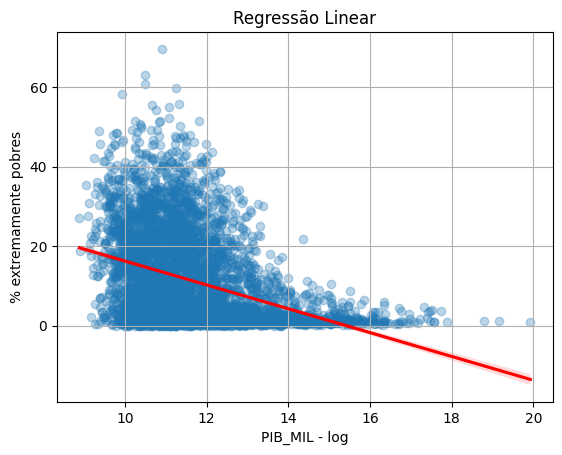

In [127]:
sns.regplot(x=X_train, y=y_train, line_kws={"color":"r"}, scatter_kws={"alpha":0.3})
plt.grid(True)
plt.title("Regressão Linear")
plt.xlabel("PIB_MIL - log")
plt.ylabel("% extremamente pobres");

In [128]:
def avaliacao(y_test, y_pred):    
    # Avaliação:
    mse = mean_squared_error(y_test, y_pred) 
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f"Mean squared error: {mse}")
    print(f"Mean absolute percentage error: {mape}")

In [129]:
avaliacao(y_test, y_pred)

Mean squared error: 125.52204405958184
Mean absolute percentage error: 471911075473173.5


### 4.2) Polynomial Regression

In [130]:
# Escolha o grau do polinômio
grau = 2

# Crie um modelo polinomial
model = make_pipeline(PolynomialFeatures(grau), LinearRegression())
model.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [131]:
def plot_modelo(model, X_train, y_train):
    X_curve = np.linspace(min(X_train)-1, max(X_train) + 1, 100).reshape(-1, 1)
    y_curve = model.predict(X_curve)
    plt.scatter(X_train, y_train, label='Dados de Treinamento', color='blue', alpha=0.5)
    plt.plot(X_curve, y_curve, label='Curva do Polinômio', color='red')
    plt.xlabel('PIB_MIL - log')
    plt.ylabel('% extremamente pobres')
    plt.legend()
    plt.title('Modelo Polinomial vs. Dados de Treinamento')
    plt.grid(True)
    plt.show()
    

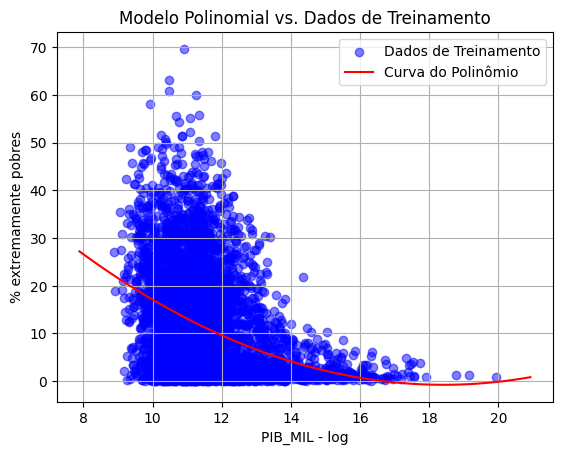

In [132]:
plot_modelo(model, X_train, y_train)

In [133]:
y_pred_poly = model.predict(X_test)
avaliacao(y_test, y_pred_poly)

Mean squared error: 125.36910766304565
Mean absolute percentage error: 470197587727503.75
